## Identifying Pneumonia Patients based on X-Ray Images

**Deanna Gould**  
Phase 4 Flex Student  
Instructor: Morgan Jones  
Presentation Date: September 21, 2023

### Overview

The purpose of this project is to predict which patients have pneumonia and which ones don't by using neural networks and image classification of X-ray images. Based on the [CDC Website](https://www.cdc.gov/nchs/fastats/pneumonia.htm), 41,309 people die from pneumonia each year, and 1.5 million people visit the emergency room with pneumonia as the primary diagnosis. By creating machine learning models, healthcare providers may be able to predict and identify which patients have pneumonia. Although this wouldn't be able to completely replace a doctor's part in diagnosing the patient, this could be used as an added precaution.

The dataset consists of 4,818 images for train data, 418 images for test data, and 624 images for validation data. Different algorithms will be used and each model will be tuned to determine the best model.

### Importing Libraries

In [1]:
# Importing libraries

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (plot_confusion_matrix, confusion_matrix, classification_report, roc_curve, auc, 
                             RocCurveDisplay)
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

### Creating Functions

In [2]:
# Creating a function for plot history 

def plot_history(history):
    acc = history.history['binary_accuracy']
    val_acc = history.history['val_binary_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'pink', label='Training accuracy')
    plt.plot(epochs, val_acc, 'blue', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.figure()
    plt.show();

In [3]:
# Creating a function for rocauc

def plot_roc_auc(y_true, y_score):
    """
    This function plots an ROC curve and gives the AUC score of a model's predictions and a generator's true labels.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_score)

    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(fpr, tpr, color='blue',
         lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='pink', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [61]:
# Creating a function

# Code below from stack overflow
# https://stackoverflow.com/questions/45413712/keras-get-true-labels-y-test-from-imagedatagenerator-or-predict%20%20%20%20%20-generator/67282636#67282636

def pred_labels(model, generator):

# Create lists for storing the predictions and labels
# Labels in this case are actual values and predictions are predicted values
    predictions = []
    labels = []

# Get the total number of labels in generator 
# (i.e. the length of the dataset where the generator generates batches from)
    n = len(generator.labels)

# Loop over the generator
    for data, label in generator:
    # Make predictions on data using the model. Store the results.
        predictions.extend(model.predict(data, workers = 4).flatten())

    # Store corresponding labels
        labels.extend(label)

    # We have to break out from the generator when we've processed 
    # the entire once (otherwise we would end up with duplicates). 
        if (len(label) < generator.batch_size) and (len(predictions) == n):
            break
    return labels, predictions

In [5]:
#Creating a function to plot 
def conf_matrix(y_true, y_pred):
    '''
    This function plots a regular confusion matrix. It takes predictions generated from the get_predictions
    function and calculates true positive, false positive, true negative and false negative counts.
    
    '''
    #Converting probabilities to 0 and 1
    y_pred = np.array([round(x) for x in y_pred])
    
    cm = confusion_matrix(y_true, y_pred)
    
    #Plotting confusion matrix using heatmap
    fig, ax = plt.subplots(figsize = (16, 10))
    ax = sns.heatmap(cm, annot=True, cmap='flare', fmt='g')

    ax.set_title('Predictions for Pneumonia cases\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Normal','Pneumonia'])
    ax.yaxis.set_ticklabels(['Normal','Pneumonia'])

    ## Display the visualization of the Confusion Matrix.
    plt.show();
    
    #Calculating normalization
    row_sums = cm.sum(axis=1)
    new_matrix = np.round(cm / row_sums[:, np.newaxis], 3)
    
    #Plotting confusion matrix using heatmap
    fig, ax = plt.subplots(figsize = (16, 10))
    ax = sns.heatmap(new_matrix, annot=True, cmap='flare', fmt='g')

    ax.set_title('Predictions for Pneumonia cases\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Normal','Pneumonia'])
    ax.yaxis.set_ticklabels(['Normal','Pneumonia'])

    ## Display the visualization of the Confusion Matrix.
    plt.show();

In [6]:
# Making directories

train_dir = "data/chest_xray/chest_xray/train"
val_dir = "data/chest_xray/chest_xray/val"
test_dir = "data/chest_xray/chest_xray/test"

In [7]:
# Getting value counts for directories


print('train_set:')
print('---------')
pneu_count_tr = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
normal_count_tr = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f'Pneumonia = {pneu_count_tr}')
print(f'Normal = {normal_count_tr}')
print('\n')
print('val_set:')
print('---------')
pneu_count_val = len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))
normal_count_val = len(os.listdir(os.path.join(val_dir, 'NORMAL')))
print(f'Pneumonia = {pneu_count_val}')
print(f'Normal = {normal_count_val}')
print('\n')
print('test_set:')
print('---------')
pneu_count_test = len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))
normal_count_test = len(os.listdir(os.path.join(test_dir, 'NORMAL')))
print(f'Pneumonia = {pneu_count_test}')
print(f'Normal = {normal_count_test}')
print('\n') 

train_set:
---------
Pneumonia = 3476
Normal = 942


val_set:
---------
Pneumonia = 409
Normal = 409


test_set:
---------
Pneumonia = 390
Normal = 234




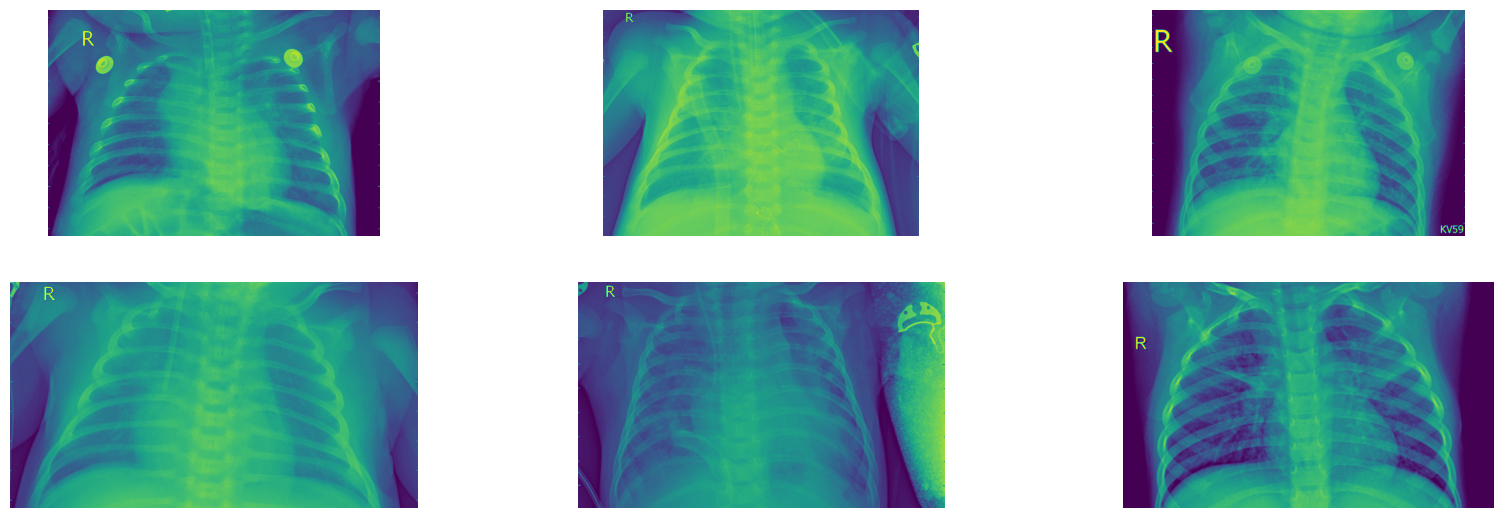

In [8]:
# Displaying Pneumonia X-rays
pneumonia = os.listdir("data/chest_xray/chest_xray/train/PNEUMONIA")
pneumoniadir = "data/chest_xray/chest_xray/train/PNEUMONIA"


# Plotting the X-rays
plt.figure(figsize = (20, 10))
for i in range(6):
    plt.subplot(3, 3, i+1)
    image = plt.imread(os.path.join(pneumoniadir, pneumonia[i]))
    plt.imshow(image)
    plt.axis('off')

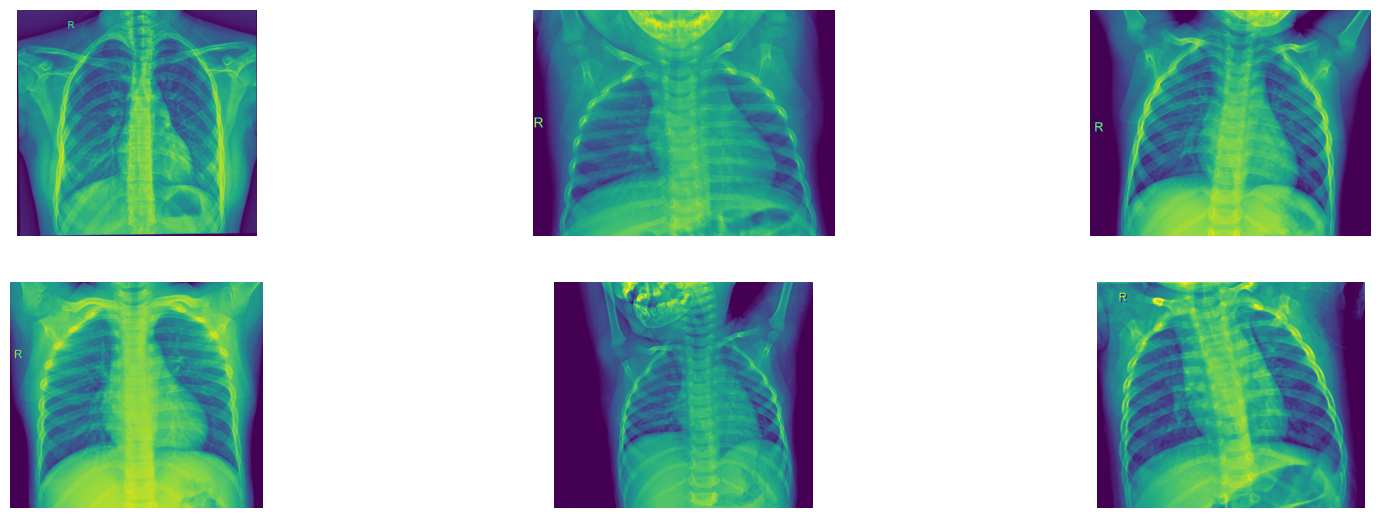

In [9]:
# Displaying Normal X-rays
normal = os.listdir("data/chest_xray/chest_xray/train/NORMAL")
normaldir = "data/chest_xray/chest_xray/train/NORMAL"

plt.figure(figsize = (20, 10))
for i in range(6):
    plt.subplot(3, 3, i+1)
    image = plt.imread(os.path.join(normaldir, normal[i]))
    plt.imshow(image)
    plt.axis('off')

In [10]:
# Reading the normal images

normal_img = plt.imread(os.path.join(normaldir, normal[0]))
normal_img

array([[ 0, 23, 24, ...,  0,  0,  0],
       [ 0,  5, 23, ...,  0,  0,  0],
       [ 1,  0, 26, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

In [11]:
# Reading the pneumonia images

pneumonia_img = plt.imread(os.path.join(pneumoniadir, pneumonia[0]))
pneumonia_img

array([[ 0,  0,  0, ..., 47, 46, 45],
       [ 0,  0,  0, ..., 45, 45, 45],
       [ 2,  1,  0, ..., 47, 47, 47],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

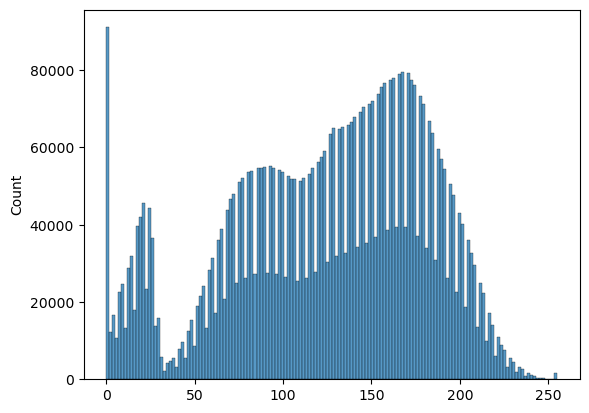

In [12]:
# Plotting the pixels of the images

sns.histplot(normal_img.ravel(), bins = 150);

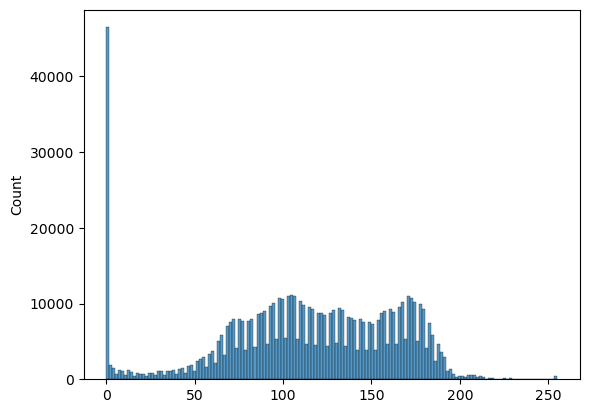

In [13]:
# Plotting the pixels of pneumonia images

sns.histplot(pneumonia_img.ravel(), bins = 150);

### Image Generator

In [14]:
# Separating train and val datagen

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(224, 224), 
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    shuffle = True)


validation_generator = val_datagen.flow_from_directory(val_dir,
                                                        target_size=(224, 224),
                                                        batch_size=32,
                                                        class_mode='binary',
                                                        shuffle = True)

Found 4416 images belonging to 2 classes.
Found 816 images belonging to 2 classes.


In [15]:
# Checking classes for the validation generator

validation_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [16]:
# Getting class weights

weight_pneu = pneu_count_tr / (pneu_count_tr + normal_count_tr)

weight_normal = normal_count_tr / (pneu_count_tr + normal_count_tr)

class_weight = {0 : weight_pneu, 1 : weight_normal}
print(f'0 Weight Class = {weight_pneu}')
print(f'1 Weight Class = {weight_normal}')

0 Weight Class = 0.7867813490267089
1 Weight Class = 0.21321865097329107


### Baseline Model

In [17]:
#Initiating the model
modelone = models.Sequential()

# Input layer
modelone.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
modelone.add(layers.MaxPooling2D((2, 2)))

#Hidden Layer
modelone.add(layers.Flatten())
modelone.add(layers.Dense(64, activation='relu'))

#Output Layer
modelone.add(layers.Dense(1, activation='sigmoid'))

modelone.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5)
                )

2023-09-22 08:42:37.468769: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 08:42:37.481955: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe5390a4570 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-09-22 08:42:37.481969: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Only thing that will change is optimizer

In [18]:
# Getting summary for model one

modelone.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 394272)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                25233472  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 25,234,433
Trainable params: 25,234,433
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Fitting the first model

historyone = modelone.fit(train_generator, 
                              epochs=10, 
                              validation_data=validation_generator,
                              class_weight = class_weight,
                              steps_per_epoch = 100,
                              validation_steps=10)

Epoch 1/10
100/100 [==============================] - 64s 639ms/step - loss: 0.2251 - binary_accuracy: 0.7253 - val_loss: 0.3320 - val_binary_accuracy: 0.8938
Epoch 2/10
100/100 [==============================] - 61s 610ms/step - loss: 0.1105 - binary_accuracy: 0.8600 - val_loss: 0.3416 - val_binary_accuracy: 0.8562
Epoch 3/10
100/100 [==============================] - 61s 608ms/step - loss: 0.0845 - binary_accuracy: 0.8950 - val_loss: 0.1988 - val_binary_accuracy: 0.9187
Epoch 4/10
100/100 [==============================] - 58s 579ms/step - loss: 0.0666 - binary_accuracy: 0.9247 - val_loss: 0.2769 - val_binary_accuracy: 0.8625
Epoch 5/10
100/100 [==============================] - 66s 660ms/step - loss: 0.0551 - binary_accuracy: 0.9397 - val_loss: 0.1569 - val_binary_accuracy: 0.9500
Epoch 6/10
100/100 [==============================] - 84s 837ms/step - loss: 0.0468 - binary_accuracy: 0.9416 - val_loss: 0.1178 - val_binary_accuracy: 0.9656
Epoch 7/10
100/100 [==========================

#### Baseline Training Validation Accuracy

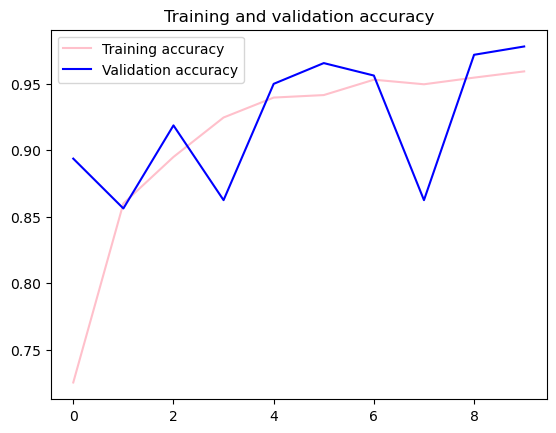

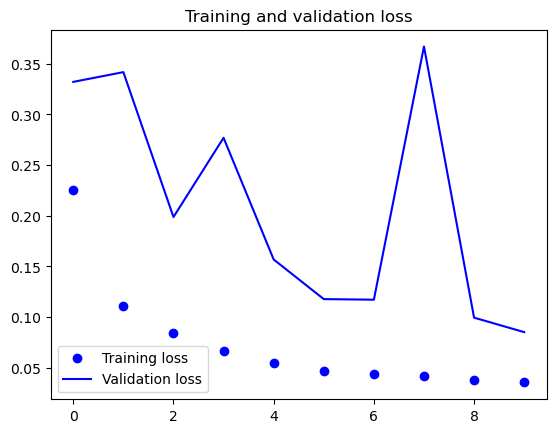

<Figure size 640x480 with 0 Axes>

In [20]:
# Plotting history for model one

plot_history(historyone)

### Baseline Predictions Check

In [21]:
# Getting prediction labels

# modelone_preds = pred_labels(modelone, train_generator)

In [22]:
modelone_predsval = pred_labels(modelone, validation_generator)

In [23]:
# plot_roc_auc(modelone_preds[0], modelone_preds[1])

AUC: 0.9754901960784313


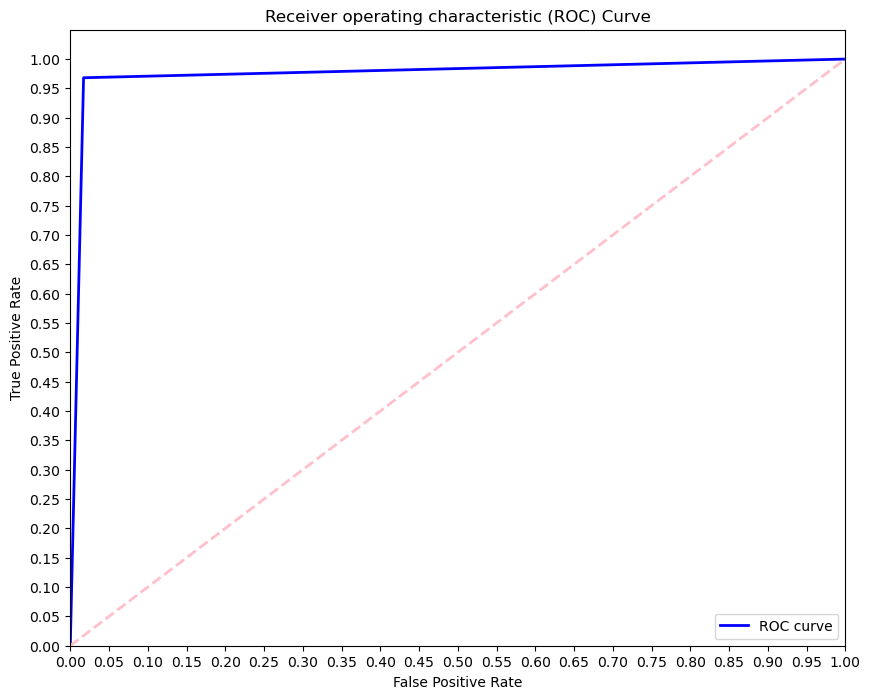

In [24]:
plot_roc_auc(modelone_predsval[0], modelone_predsval[1])

This graph means it learned quickly

In [25]:
# conf_matrix(modelone_preds[0], modelone_preds[1])

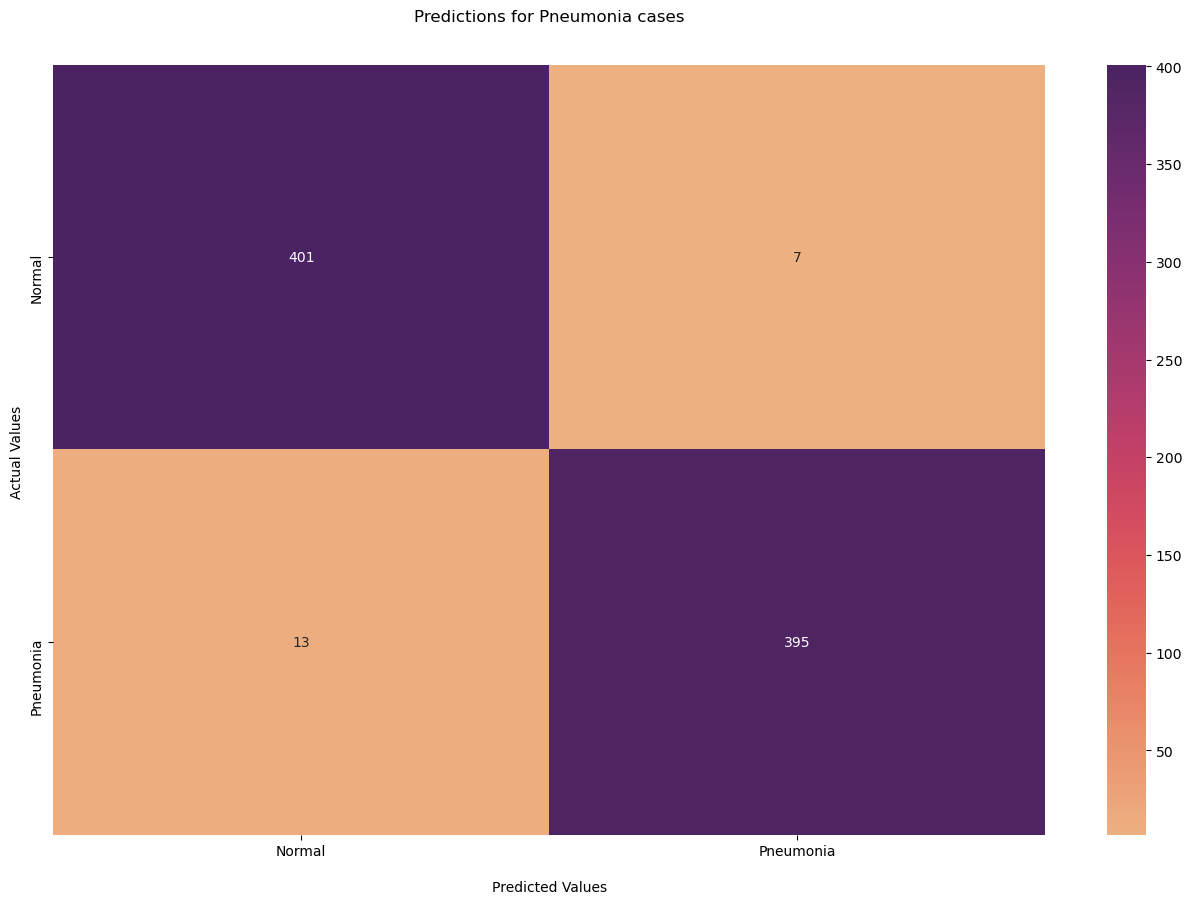

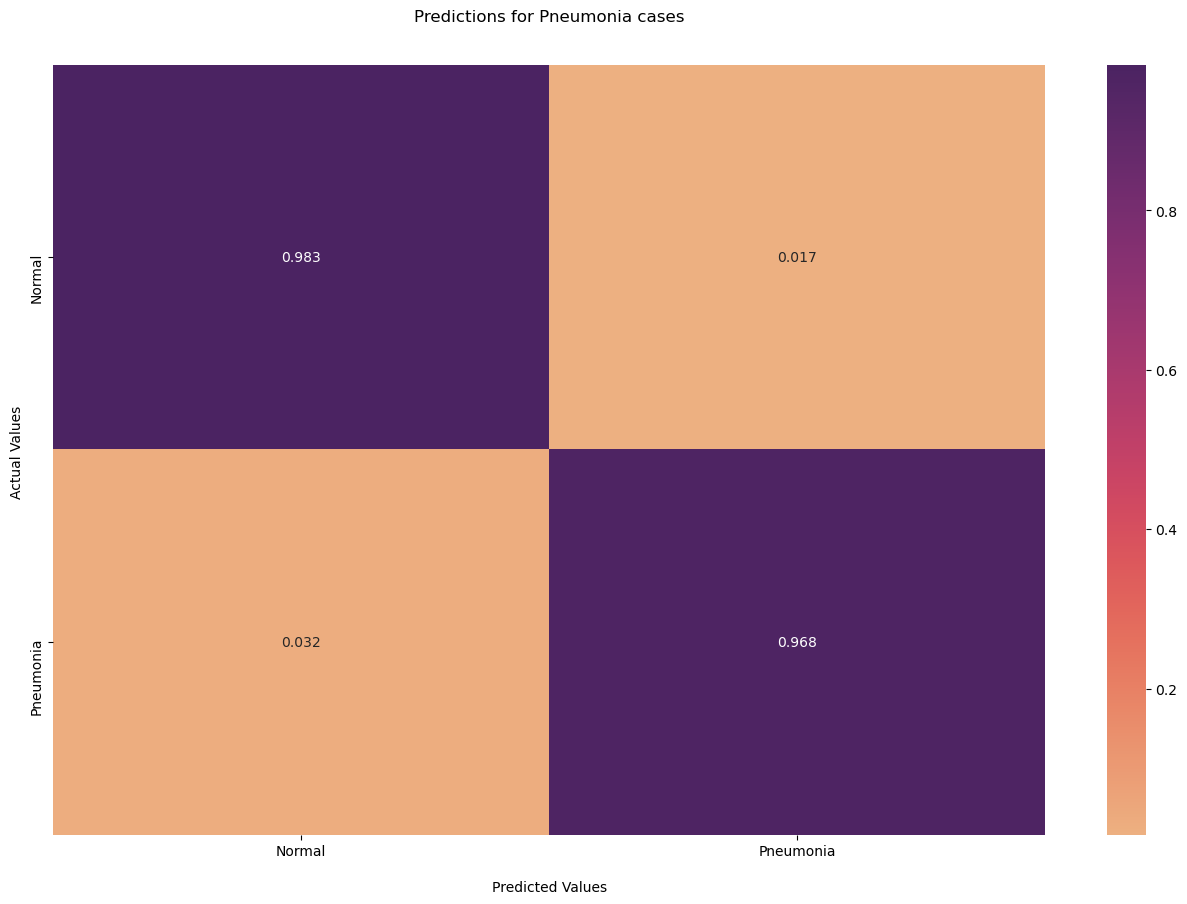

In [26]:
conf_matrix(modelone_predsval[0], modelone_predsval[1])

### HParams

In [27]:
# Creating the hparam variables

HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([64, 128]))
HP_DROPOUT = hp.HParam('dropout_rate', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'rmsprop']))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([0.01, 0.001, 0.0001]))
METRIC_ACCURACY = 'binary_accuracy'

In [28]:
#Creating a directory for logs
logdir = 'logs/hparam_tuning'

In [29]:
logdir

'logs/hparam_tuning'

In [30]:
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER, HP_LEARNING_RATE],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='binary_accuracy')],
  )

In [31]:
'''
This function uses the baseline model as it's base model. It changes the nodes, optimizer, dropout and learning 
rate based on the set params in the HParams. 
    
'''

# Creating function to do an HParams search
def create_model_grid(hparams):
    #Initializing model
    model = models.Sequential()
    
    #Adding CNN input layer
    model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (224, 224, 3)))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(hparams[HP_DROPOUT]))
    
    #Adding Dense hidden layer
    model.add(layers.Flatten())
    model.add(layers.Dense(hparams[HP_NUM_UNITS], activation = 'relu'))
    model.add(layers.Dropout(hparams[HP_DROPOUT]))
    
    #Adding output layer
    model.add(layers.Dense(1, activation = 'sigmoid'))
    
    #Looping through optimizers and learning rates
    optimizer = hparams[HP_OPTIMIZER]
    learning_rate = hparams[HP_LEARNING_RATE]
    if optimizer == "adam":
        optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer=='rmsprop':
        optimizer = tf.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("unexpected optimizer name: %r" % (optimizer_name,))
    
    #Compiling model
    model.compile(loss= 'binary_crossentropy', 
    optimizer= optimizer, 
    metrics= tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5))
    
    #Fitting model
    history=model.fit(
    train_generator, #Using train data
    steps_per_epoch=100, #Keeping 100 steps
    epochs=10, #Keeping 10 epochs
    validation_data=validation_generator, #Using validation data
    class_weight = class_weight, #Adding weights to deal with imbalance
    validation_steps=10, #Keeping 10 steps
    )
    
    return history.history['val_binary_accuracy'][-1]

In [32]:
# Creaating run function

def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = create_model_grid(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [33]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
        for learning_rate in HP_LEARNING_RATE.domain.values:
            hparams = {
              HP_NUM_UNITS: num_units,
              HP_DROPOUT: dropout_rate,
              HP_OPTIMIZER: optimizer,
              HP_LEARNING_RATE: learning_rate
              }
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            run('logs/hparam_tuning/' + run_name, hparams)
            session_num += 1

--- Starting trial: run-0
{'num_units': 64, 'dropout_rate': 0.1, 'optimizer': 'adam', 'learning_rate': 0.0001}
Epoch 1/10
100/100 [==============================] - 80s 799ms/step - loss: 0.1478 - binary_accuracy: 0.8112 - val_loss: 0.2019 - val_binary_accuracy: 0.9406
Epoch 2/10
100/100 [==============================] - 81s 814ms/step - loss: 0.0591 - binary_accuracy: 0.9325 - val_loss: 0.1884 - val_binary_accuracy: 0.9344
Epoch 3/10
100/100 [==============================] - 79s 786ms/step - loss: 0.0423 - binary_accuracy: 0.9519 - val_loss: 0.1520 - val_binary_accuracy: 0.9406
Epoch 4/10
100/100 [==============================] - 79s 789ms/step - loss: 0.0415 - binary_accuracy: 0.9509 - val_loss: 0.1336 - val_binary_accuracy: 0.9375
Epoch 5/10
100/100 [==============================] - 79s 794ms/step - loss: 0.0255 - binary_accuracy: 0.9734 - val_loss: 0.0708 - val_binary_accuracy: 0.9781
Epoch 6/10
100/100 [==============================] - 81s 809ms/step - loss: 0.0217 - binary_a

Epoch 9/10
100/100 [==============================] - 92s 916ms/step - loss: 0.0322 - binary_accuracy: 0.9678 - val_loss: 0.1489 - val_binary_accuracy: 0.9625
Epoch 10/10
100/100 [==============================] - 90s 896ms/step - loss: 0.0331 - binary_accuracy: 0.9641 - val_loss: 0.0776 - val_binary_accuracy: 0.9656
--- Starting trial: run-5
{'num_units': 64, 'dropout_rate': 0.1, 'optimizer': 'rmsprop', 'learning_rate': 0.01}
Epoch 1/10
100/100 [==============================] - 90s 897ms/step - loss: 12.3977 - binary_accuracy: 0.4300 - val_loss: 0.6931 - val_binary_accuracy: 0.5031
Epoch 2/10
100/100 [==============================] - 92s 918ms/step - loss: 0.2309 - binary_accuracy: 0.7550 - val_loss: 0.6934 - val_binary_accuracy: 0.4719
Epoch 3/10
100/100 [==============================] - 90s 896ms/step - loss: 0.2327 - binary_accuracy: 0.5312 - val_loss: 0.6931 - val_binary_accuracy: 0.5156
Epoch 4/10
100/100 [==============================] - 90s 896ms/step - loss: 0.2319 - binar

Epoch 7/10
100/100 [==============================] - 91s 906ms/step - loss: 0.0870 - binary_accuracy: 0.9009 - val_loss: 0.2014 - val_binary_accuracy: 0.9250
Epoch 8/10
100/100 [==============================] - 91s 913ms/step - loss: 0.0794 - binary_accuracy: 0.9162 - val_loss: 0.1346 - val_binary_accuracy: 0.9688
Epoch 9/10
100/100 [==============================] - 93s 930ms/step - loss: 0.0821 - binary_accuracy: 0.9087 - val_loss: 0.1046 - val_binary_accuracy: 0.9812
Epoch 10/10
100/100 [==============================] - 91s 908ms/step - loss: 0.0758 - binary_accuracy: 0.9147 - val_loss: 0.1448 - val_binary_accuracy: 0.9438
--- Starting trial: run-10
{'num_units': 64, 'dropout_rate': 0.2, 'optimizer': 'rmsprop', 'learning_rate': 0.001}
Epoch 1/10
100/100 [==============================] - 91s 910ms/step - loss: 1.1399 - binary_accuracy: 0.7803 - val_loss: 0.8600 - val_binary_accuracy: 0.6062
Epoch 2/10
100/100 [==============================] - 91s 910ms/step - loss: 0.1069 - bina

Epoch 5/10
100/100 [==============================] - 96s 961ms/step - loss: 0.0944 - binary_accuracy: 0.8766 - val_loss: 0.6416 - val_binary_accuracy: 0.7406
Epoch 6/10
100/100 [==============================] - 92s 918ms/step - loss: 0.1132 - binary_accuracy: 0.8225 - val_loss: 0.4270 - val_binary_accuracy: 0.7969
Epoch 7/10
100/100 [==============================] - 93s 925ms/step - loss: 0.0733 - binary_accuracy: 0.9069 - val_loss: 0.4151 - val_binary_accuracy: 0.8375
Epoch 8/10
100/100 [==============================] - 94s 945ms/step - loss: 0.0642 - binary_accuracy: 0.9328 - val_loss: 0.5685 - val_binary_accuracy: 0.7812
Epoch 9/10
100/100 [==============================] - 94s 941ms/step - loss: 0.0499 - binary_accuracy: 0.9622 - val_loss: 0.5987 - val_binary_accuracy: 0.8188
Epoch 10/10
100/100 [==============================] - 93s 925ms/step - loss: 0.0285 - binary_accuracy: 0.9700 - val_loss: 0.7374 - val_binary_accuracy: 0.8250
--- Starting trial: run-15
{'num_units': 128,

100/100 [==============================] - 90s 901ms/step - loss: 0.0447 - binary_accuracy: 0.9488 - val_loss: 0.0943 - val_binary_accuracy: 0.9812
Epoch 4/10
100/100 [==============================] - 93s 929ms/step - loss: 0.0244 - binary_accuracy: 0.9731 - val_loss: 0.1292 - val_binary_accuracy: 0.9500
Epoch 5/10
100/100 [==============================] - 89s 892ms/step - loss: 0.0192 - binary_accuracy: 0.9787 - val_loss: 0.0793 - val_binary_accuracy: 0.9719
Epoch 6/10
100/100 [==============================] - 89s 893ms/step - loss: 0.0179 - binary_accuracy: 0.9809 - val_loss: 0.0896 - val_binary_accuracy: 0.9594
Epoch 7/10
100/100 [==============================] - 91s 909ms/step - loss: 0.0154 - binary_accuracy: 0.9850 - val_loss: 0.1383 - val_binary_accuracy: 0.9500
Epoch 8/10
100/100 [==============================] - 92s 923ms/step - loss: 0.0078 - binary_accuracy: 0.9919 - val_loss: 0.0661 - val_binary_accuracy: 0.9781
Epoch 9/10
100/100 [==============================] - 89s

Best parameters of this search are: 

--- Starting trial: run-3
{'num_units': 64, 'dropout_rate': 0.1, 'optimizer': 'rmsprop', 'learning_rate': 0.0001}

--- Starting trial: run-6
{'num_units': 64, 'dropout_rate': 0.2, 'optimizer': 'adam', 'learning_rate': 0.0001}

--- Starting trial: run-18
{'num_units': 128, 'dropout_rate': 0.2, 'optimizer': 'adam', 'learning_rate': 0.0001}

adam, unit 64, learning rate so now this is the model that will be tuned

--- Starting trial: run-6
{'num_units': 64, 'dropout_rate': 0.2, 'optimizer': 'adam', 'learning_rate': 0.0001}

Epoch 10/10

100/100 [==============================] - 82s 823ms/step - loss: 0.0236 - binary_accuracy: 0.9791 - val_loss: 0.0853 - val_binary_accuracy: 0.9781

### Tuning HParams

In [34]:
model2 = models.Sequential()
    
#Adding CNN input layer
model2.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (224, 224, 3)))
model2.add(layers.MaxPooling2D(2,2))
model2.add(layers.Dropout(0.2))
    
#Adding Dense hidden layer
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation = 'relu'))
model2.add(layers.Dropout(0.2))
    
#Adding output layer
model2.add(layers.Dense(1, activation = 'sigmoid'))
  
#Looping through optimizers and learning rates

#Compiling model
model2.compile(loss= 'binary_crossentropy', 
optimizer= optimizers.Adam(lr = 1e-4), 
metrics= tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5))

In [35]:
model2.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 111, 111, 32)      0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 394272)            0         
_________________________________________________________________
dense_50 (Dense)             (None, 64)                25233472  
_________________________________________________________________
dropout_49 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 1)               

In [36]:
#Fitting model

history_hparams=model2.fit(
train_generator, #Using train data
steps_per_epoch=30, #Keeping 30 steps
epochs=10, #Keeping 10 epochs
validation_data=validation_generator, #Using validation data
class_weight = class_weight, #Adding weights to deal with imbalance
validation_steps=10, #Keeping 10 steps
)

Epoch 1/10
30/30 [==============================] - 29s 959ms/step - loss: 0.2903 - binary_accuracy: 0.6510 - val_loss: 0.5701 - val_binary_accuracy: 0.8531
Epoch 2/10
30/30 [==============================] - 27s 904ms/step - loss: 0.1764 - binary_accuracy: 0.7281 - val_loss: 0.4965 - val_binary_accuracy: 0.8500
Epoch 3/10
30/30 [==============================] - 28s 926ms/step - loss: 0.1567 - binary_accuracy: 0.7625 - val_loss: 0.4484 - val_binary_accuracy: 0.8562
Epoch 4/10
30/30 [==============================] - 28s 921ms/step - loss: 0.1435 - binary_accuracy: 0.7625 - val_loss: 0.3687 - val_binary_accuracy: 0.8750
Epoch 5/10
30/30 [==============================] - 28s 924ms/step - loss: 0.1402 - binary_accuracy: 0.7844 - val_loss: 0.3556 - val_binary_accuracy: 0.8813
Epoch 6/10
30/30 [==============================] - 28s 920ms/step - loss: 0.1144 - binary_accuracy: 0.8146 - val_loss: 0.3246 - val_binary_accuracy: 0.8750
Epoch 7/10
30/30 [==============================] - 27s 91

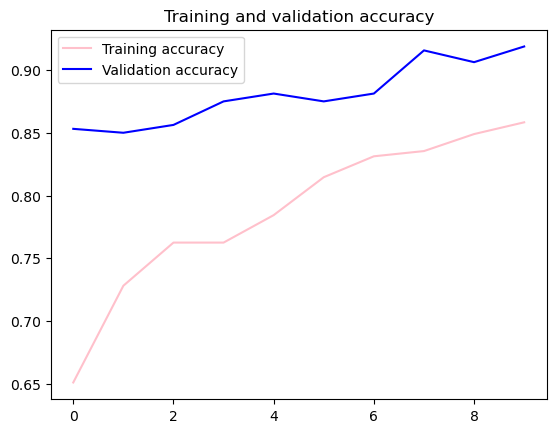

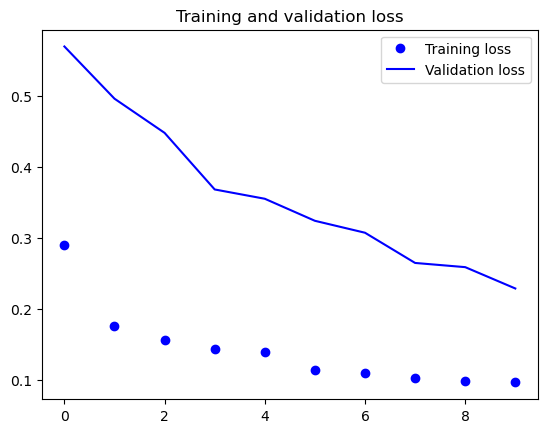

<Figure size 640x480 with 0 Axes>

In [37]:
plot_history(history_hparams)

### HParams Predictions Check

In [38]:
# Getting prediction labels

# model2_preds = pred_labels(model2, train_generator)

In [42]:
model2_predsval = pred_labels(model2, validation_generator)

In [40]:
# plot_roc_auc(model2_preds[0], model2_preds[1])

AUC: 0.9325980392156862


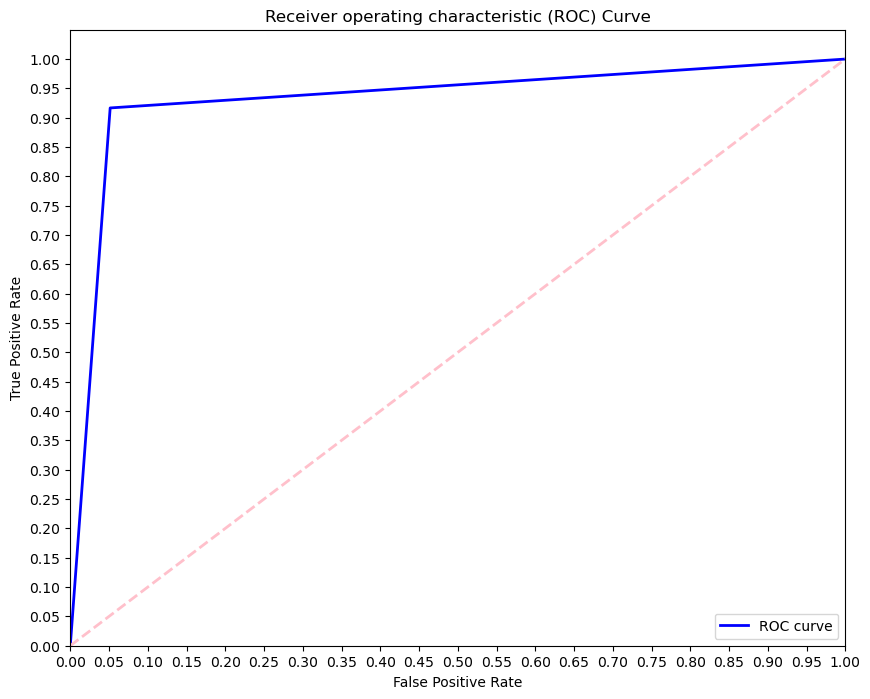

In [43]:
plot_roc_auc(model2_predsval[0], model2_predsval[1])

This graph means it learned quickly

In [45]:
# conf_matrix(model2_preds[0], model2_preds[1])

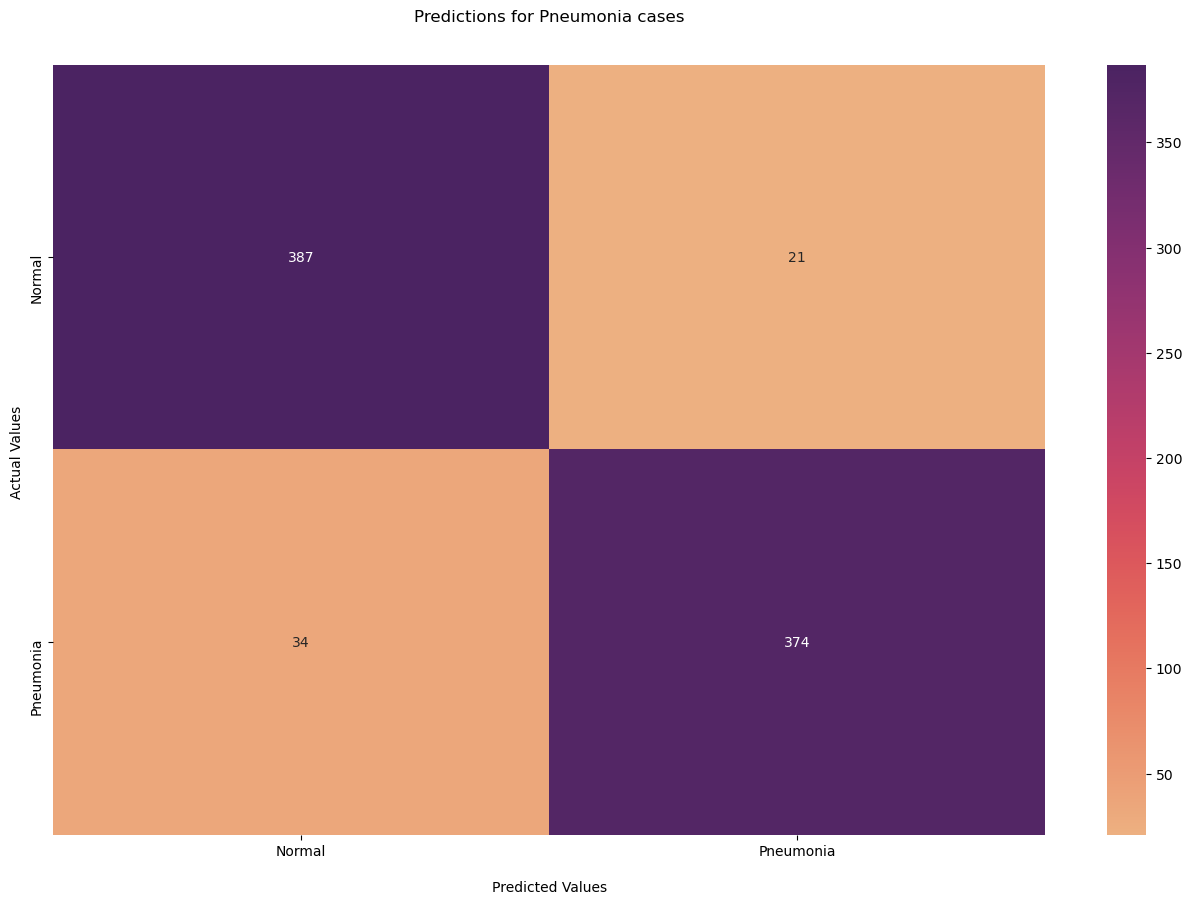

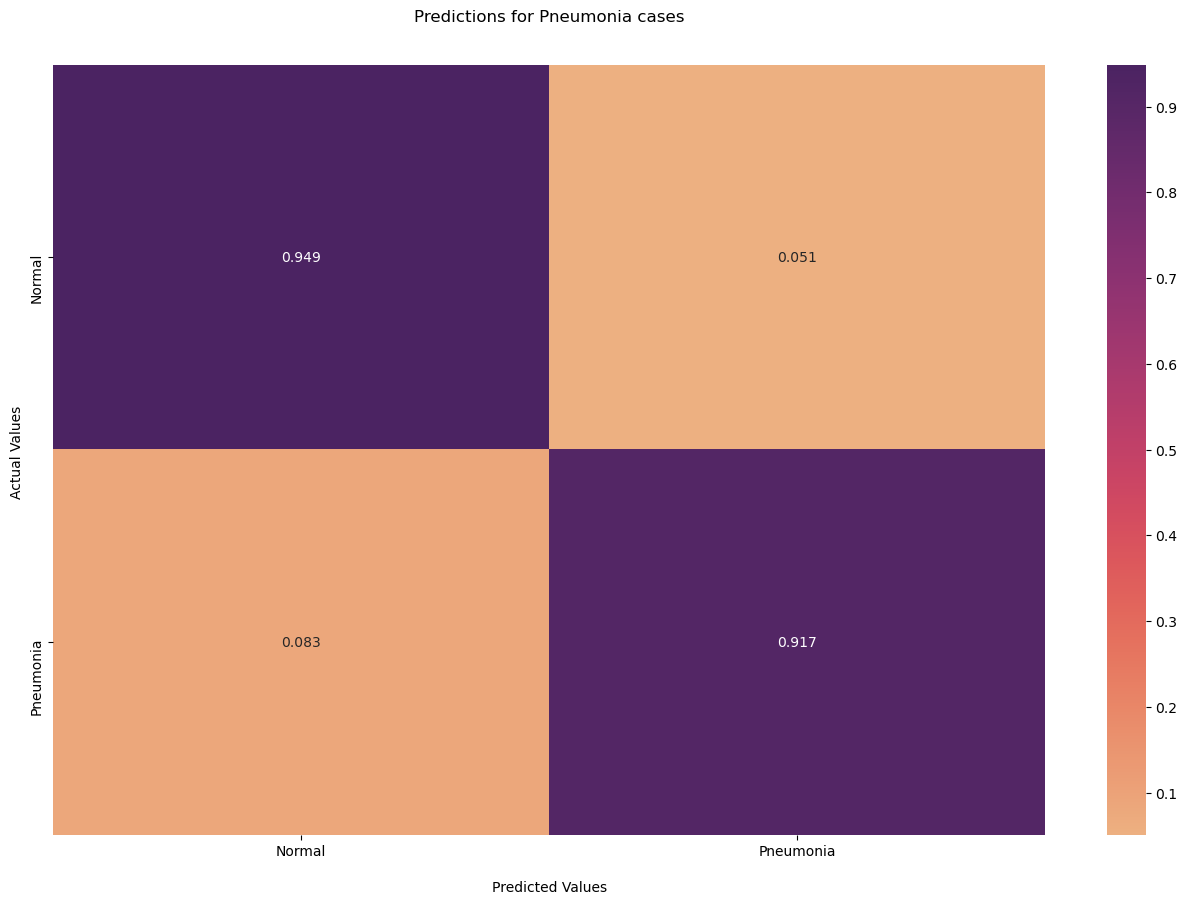

In [46]:
conf_matrix(model2_predsval[0], model2_predsval[1])

### Transfer Learning

Inception-v3

In [47]:
# 
model3 = models.Sequential()

inception_v3 = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    classes=1
)


for layer in inception_v3.layers:
    layer.trainable = False

model3.add(inception_v3)

In [48]:
model3.add(layers.GlobalAveragePooling2D())
model3.add(layers.Dense(64, activation = 'relu'))
model3.add(layers.Dropout(0.2))

#Adding output layer
model3.add(layers.Dense(1, activation = 'sigmoid'))

In [49]:
# Compiling model
model3.compile(loss= 'binary_crossentropy', 
optimizer= optimizers.Adam(lr = 1e-4), 
metrics= tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5))

In [50]:
model3.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_52 (Dense)             (None, 64)                131136    
_________________________________________________________________
dropout_50 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 65        
Total params: 21,933,985
Trainable params: 131,201
Non-trainable params: 21,802,784
_________________________________________________________________


In [51]:
#Fitting model

history_transfer=model3.fit(
train_generator, #Using train data
steps_per_epoch=30, #Keeping 30 steps
epochs=10, #Keeping 10 epochs
validation_data=validation_generator, #Using validation data
class_weight = class_weight, #Adding weights to deal with imbalance
validation_steps=10, #Keeping 10 steps
)

Epoch 1/10
30/30 [==============================] - 32s 1s/step - loss: 0.2011 - binary_accuracy: 0.6719 - val_loss: 0.4134 - val_binary_accuracy: 0.8625
Epoch 2/10
30/30 [==============================] - 29s 959ms/step - loss: 0.1327 - binary_accuracy: 0.8219 - val_loss: 0.3332 - val_binary_accuracy: 0.8750
Epoch 3/10
30/30 [==============================] - 30s 989ms/step - loss: 0.1083 - binary_accuracy: 0.8604 - val_loss: 0.2622 - val_binary_accuracy: 0.9000
Epoch 4/10
30/30 [==============================] - 30s 999ms/step - loss: 0.0933 - binary_accuracy: 0.8917 - val_loss: 0.2388 - val_binary_accuracy: 0.9281
Epoch 5/10
30/30 [==============================] - 29s 983ms/step - loss: 0.0885 - binary_accuracy: 0.8885 - val_loss: 0.2309 - val_binary_accuracy: 0.9062
Epoch 6/10
30/30 [==============================] - 29s 961ms/step - loss: 0.0822 - binary_accuracy: 0.9062 - val_loss: 0.1845 - val_binary_accuracy: 0.9406
Epoch 7/10
30/30 [==============================] - 29s 979ms

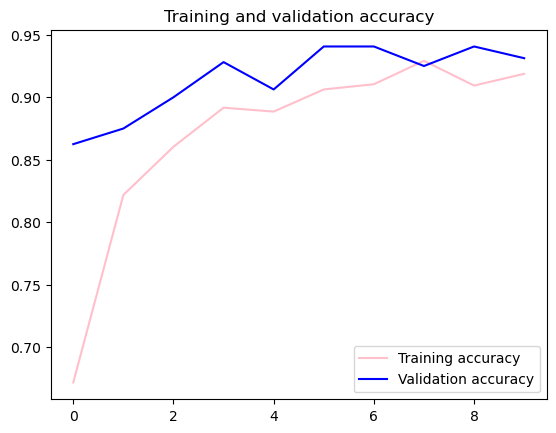

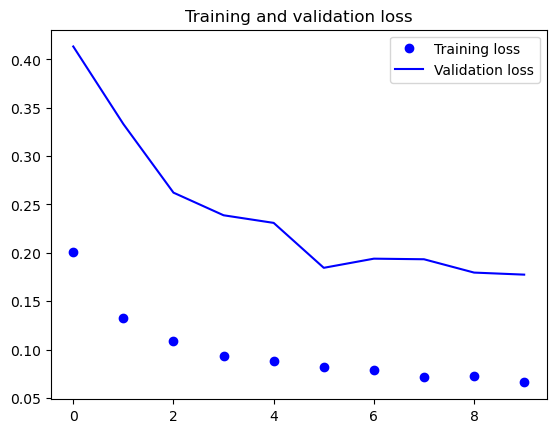

<Figure size 640x480 with 0 Axes>

In [52]:
plot_history(history_transfer)

### Transfer Learning Predictions Check

In [53]:
# Getting prediction labels

# model3_preds = pred_labels(model3, train_generator)

In [54]:
model3_predsval = pred_labels(model3, validation_generator)

In [55]:
# model3_preds[0]

In [56]:
# model3_preds[1]

In [57]:
# plot_roc_auc(model3_preds[0], model3_preds[1])

AUC: 0.9276960784313726


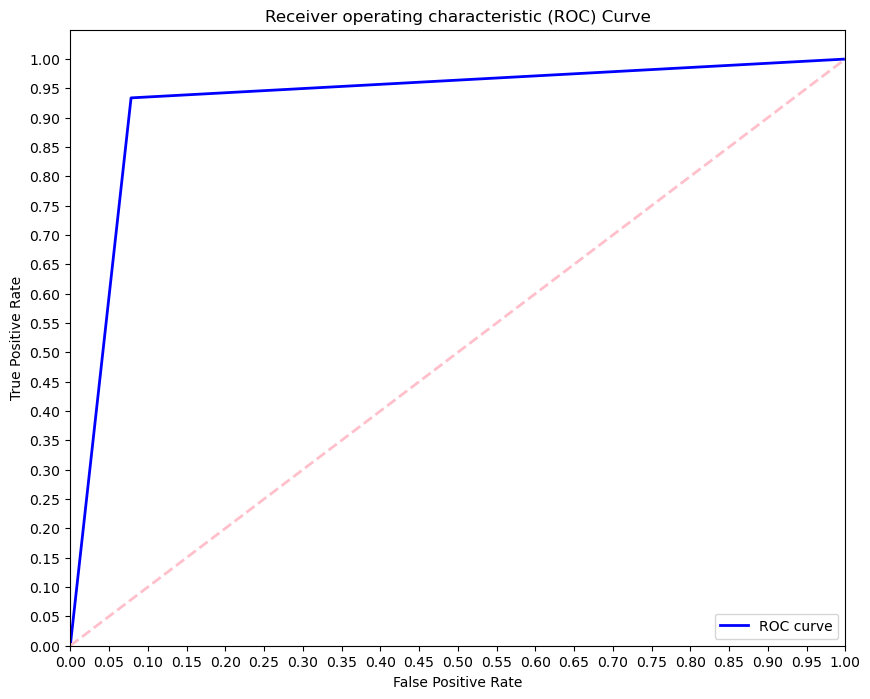

In [58]:
plot_roc_auc(model3_predsval[0], model3_predsval[1])

This graph means it learned quickly

In [59]:
# conf_matrix(model3_preds[0], model3_preds[1])

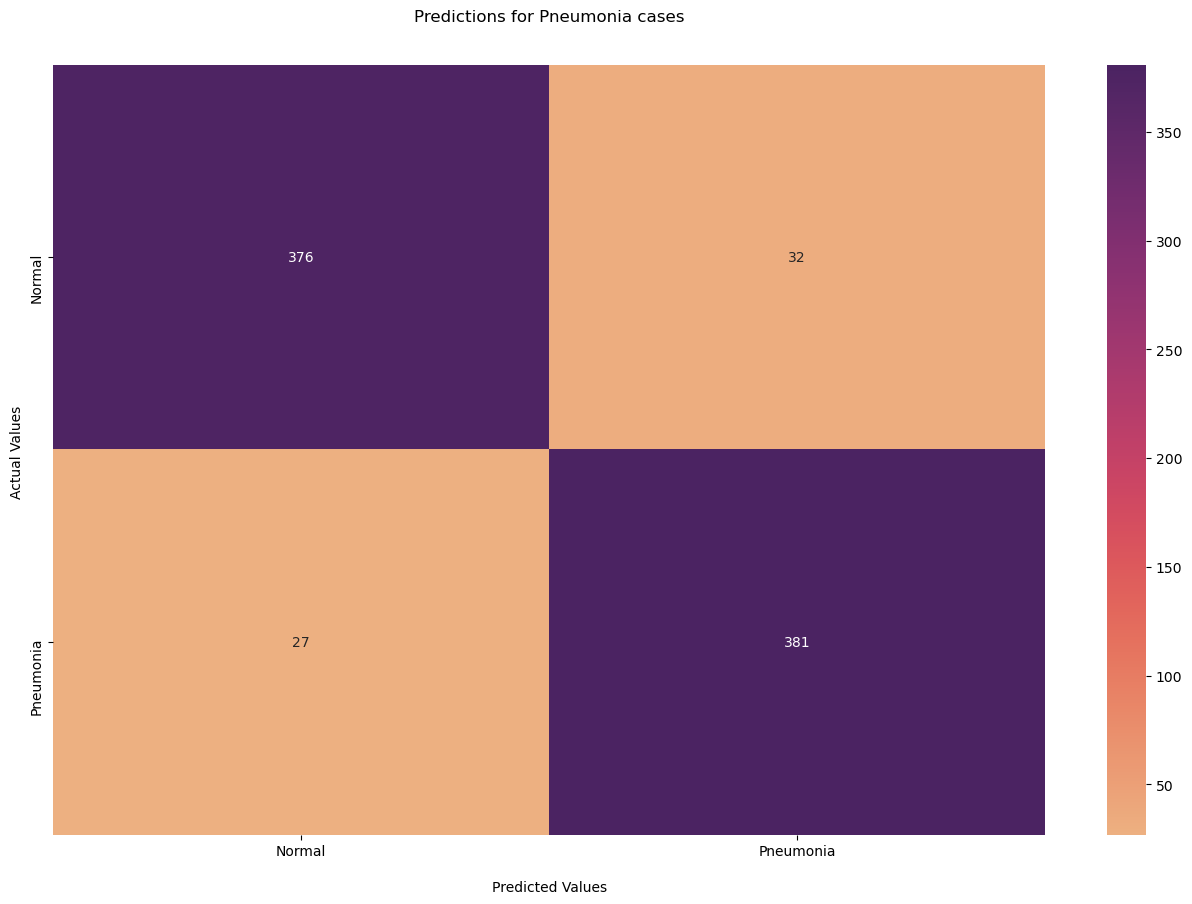

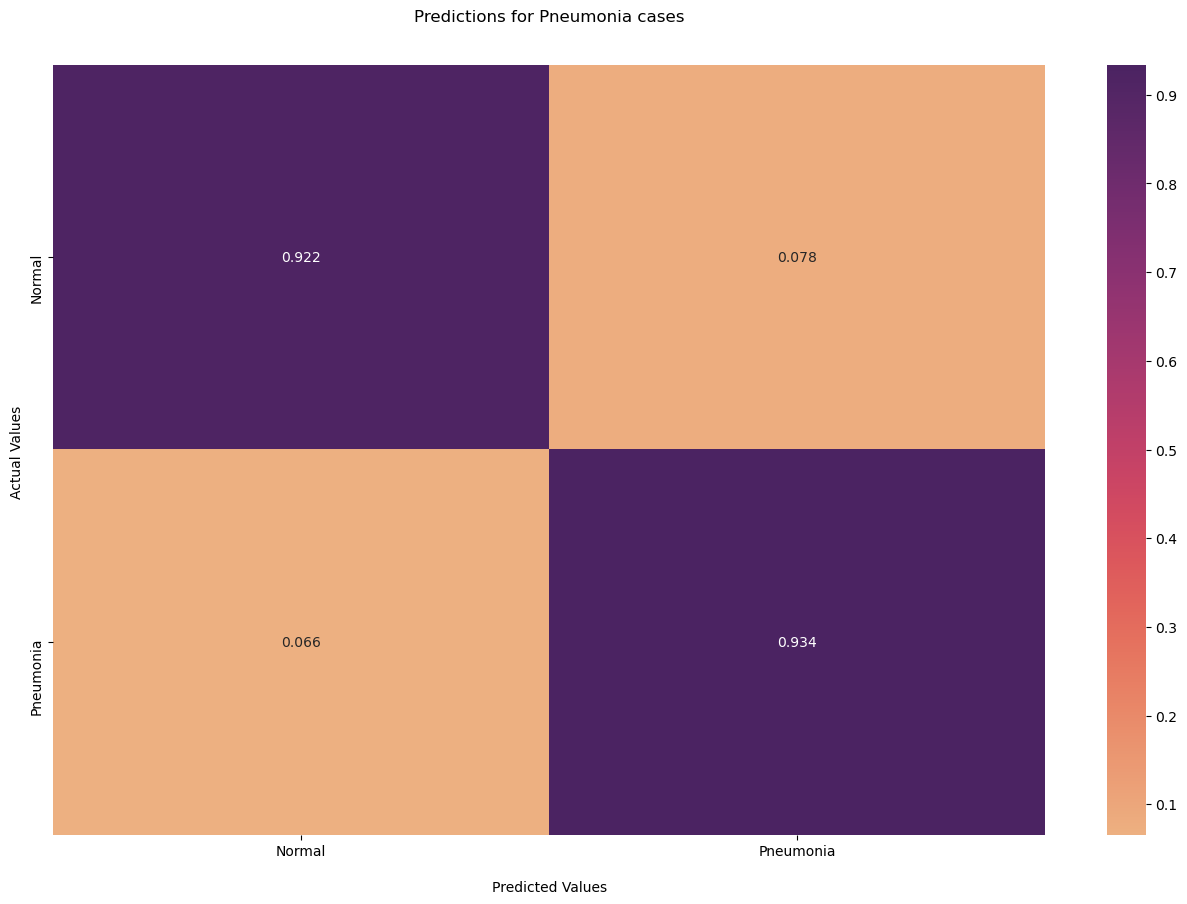

In [60]:
conf_matrix(model3_predsval[0], model3_predsval[1])


### Transfer Learning Tuned

In [ ]:
# 

model4 = models.Sequential()

inception_v3_tuned = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    classes=1
)


for layer in inception_v3_tuned.layers[:-x]:
    layer.trainable = False

for i, layer in enumerate(inception_v3_tuned.layers):
    print(i, layer.name, layer.trainable)`

In [ ]:
# Input Layer

model4.add(inception_v3_tuned)

# Hidden Layer
model4.add(layers.GlobalAveragePooling2D())
model4.add(layers.Dense(64, activation = 'relu'))
model4.add(layers.Dropout(0.2))

#Adding output layer
model4.add(layers.Dense(1, activation = 'sigmoid'))

In [ ]:
# Compiling model
model4.compile(loss= 'binary_crossentropy', 
optimizer= optimizers.Adam(lr = 1e-4), 
metrics= tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5))

In [ ]:
model4.summary()

In [ ]:
#Fitting model

history_transfertune=model4.fit(
train_generator, #Using train data
steps_per_epoch=30, #Keeping 30 steps
epochs=10, #Keeping 10 epochs
validation_data=validation_generator, #Using validation data
class_weight = class_weight, #Adding weights to deal with imbalance
validation_steps=10, #Keeping 10 steps
)

In [ ]:
# Plotting history for model one

plot_history(history_transfertune)

### Transfer Learning Predictions Check

In [ ]:
# Getting prediction labels

# model3_preds = pred_labels(model3, train_generator)

In [ ]:
model3_predsval = pred_labels(model3, validation_generator)

In [ ]:
# plot_roc_auc(model3_preds[0], model3_preds[1])

In [ ]:
plot_roc_auc(model3_predsval[0], model3_predsval[1])

This graph means it learned quickly

In [ ]:
conf_matrix(model3_preds[0], model3_preds[1])

In [ ]:
conf_matrix(model3_predsval[0], model3_predsval[1])

## Test generator

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                        target_size=(224, 224),
                                                        batch_size=32,
                                                        class_mode='binary',
                                                        shuffle = True)

In [ ]:
final_preds = pred_labels(model3, test_generator)

want the loss and training validation to be smoother/closer together
how to plot hparams ?

find model with best binary accuracy and val bin acc
go to last epoch of each model and see which one is closest
base model, grid search model, tune model after gs, transfer learning (pre trained model), tune transfer learning

pneumonia xray vs normal, class imbalance (no normals ??) confusion matrix, pneumonia histograms and explain what the pixels

explain why neural network (images are 3d, so model needs to be more complex) vs machine learning

diagram of neural network in readme potentially